In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);
from torch.utils import data

import warnings
warnings.simplefilter("ignore", UserWarning)

from pytorch_lightning.callbacks.early_stopping import EarlyStopping


## Read data

In [3]:
import sys
from dataloader import get_video_loader, train_transform, test_transform, unnormalize
import argparse

%load_ext autoreload
%autoreload 1
%aimport dataloader


In [4]:
parser = argparse.ArgumentParser(description='',
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('--batch_size', default=16, type=int, metavar='N',
                    help='batchsize')
parser.add_argument('-j', '--workers', default=0, type=int, metavar='N',
                    help='number of data loading workers')
parser.add_argument('-c', '--checkpoint',
                    default="checkpoint_bincls_newborders", type=str,
                    metavar='PATH',
                    help='path to save checkpoint')
parser.add_argument('--frames_per_clip', type=int, default=16)
parser.add_argument('--step_between_clips', type=int, default=16)
parser.add_argument('--fps', type=int, default=8)
parser.add_argument('--local_rank', type=int, default=-1)
parser.add_argument('--clips_per_video', type=int, default=1)
parser.add_argument('--fails_path', default="train/")
parser.add_argument('--dataset_path', default="train/")

_StoreAction(option_strings=['--dataset_path'], dest='dataset_path', nargs=None, const=None, default='train/', type=None, choices=None, help=None, metavar=None)

In [5]:
#args = parser.parse_args()
#args, unknown = parser.parse_known_args()

## Loss function

In [6]:
device = torch.device('cuda')

In [7]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    #while end_ind < length:
    #    start_ind = end_ind - 1
    #    if start_ind < 0:
    #        start_ind = 0
    #    end_ind = np.random.randint(start_ind, length + 2)
    #    if end_ind == start_ind:
    #        end_ind = end_ind + 1
    #    loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    #loss = torch.sum(loss)
    return loss

In [8]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 8
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss


## Model

In [9]:
import torchvision

In [10]:
mobile_net_v2 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

class FullyConnected(torch.nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
        self.clas_block1 = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, 100)
        )
        
    def forward(self, x):
        x = self.clas_block1(x)
        return x.view(-1, 100)

mobile_net_v2.classifier = FullyConnected()

Using cache found in /home/eromanenkova/.cache/torch/hub/pytorch_vision_v0.6.0


In [11]:
HIDDEN_CNN = 512
HIDDEN_LSTM = 128

class FullyConnected(torch.nn.Module):
    def __init__(self, input_size=1280):
        super(FullyConnected, self).__init__()
        self.clas_block1 = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(input_size, HIDDEN_CNN)
        )
        
    def forward(self, x):
        x = self.clas_block1(x)
        return x.view(-1, HIDDEN_CNN)


class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        
        self.cnn = mobile_net_v2
        self.rnn = nn.GRU(
            input_size=HIDDEN_CNN,  # 1280 if conv block mobile net used
            hidden_size=HIDDEN_LSTM, 
            num_layers=1,
            batch_first=True, 
            dropout=0.1)
        
        self.linear = nn.Linear(HIDDEN_LSTM, 1)      
        self.dropout = nn.Dropout(0.25)
        self.dropout_2 = nn.Dropout(0.5)        
        self.relu = nn.ReLU()  
        self.activation = nn.Sigmoid()        

    def forward(self, x):
        batch_size, C, timesteps, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        #c_out = nn.functional.adaptive_avg_pool2d(c_out, (1, 1))
        #c_out = torch.flatten(c_out, 1)
        #c_out = self.classifier(c_out)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, _ = self.rnn(r_in)
        r_out = r_out.reshape(batch_size * timesteps, -1)
        r_out = self.dropout(self.linear(r_out).view(batch_size, timesteps, -1))
        out = self.activation(r_out)
        return out    
    
mobile_net_v2 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)    
mobile_net_v2.classifier = FullyConnected()

Using cache found in /home/eromanenkova/.cache/torch/hub/pytorch_vision_v0.6.0


In [12]:
model = Combine() 

cnt = 0
for param in model.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False

In [13]:
device = 'cuda:0'

In [14]:
import pytorch_lightning as pl
import torch
import torch.nn as nn

class CPD_model(pl.LightningModule):
    def __init__(
        self,
        model, 
        lr: float = None,
        batch_size: int = 16,
        loss_type: str = 'bce'
    ):
        super(CPD_model, self).__init__()

        self.model = model
        self.lr = lr
        self.batch_size = batch_size
        
        if loss_type == 'bce':
            self.loss = nn.BCELoss()
        else:
            self.loss = CustomLoss()
            
        
    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        videos, labels, _ = batch
        pred = self.forward(videos.float())

        train_loss = self.loss(pred.squeeze(), labels.float().squeeze())
        train_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()

        self.log('train_loss', train_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', train_accuracy, prog_bar=True, on_epoch=True)
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        videos, labels, _ = batch
        pred = self.forward(videos.float())
        
        val_loss = self.loss(pred.squeeze(), labels.float().squeeze())      
        val_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
                
        self.log('val_loss', val_loss, prog_bar=True)    
        self.log('val_acc', val_accuracy, prog_bar=True)    
        
        return {'val_loss': val_loss, 'val_acc': val_accuracy}
    

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=0.001) 
        #stp = torch.optim.lr_scheduler.StepLR(opt, 5, gamma=0.9)

        return [opt] #, [stp]

    def train_dataloader(self):
        
        train_args = ['--batch_size', str(self.batch_size), '--workers', '4', '--checkpoint', 'checkpoint_bincls_newborders', 
                      '--frames_per_clip', '16', '--step_between_clips', '16', '--fps', '8',
                      '--local_rank', '-1', '--clips_per_video', '1', '--fails_path', 'new_train/', '--dataset_path', "new_train/"]
        train_args = parser.parse_args(train_args)
        return get_video_loader(**vars(train_args), val=False, transform=train_transform)
    
    def val_dataloader(self):
        
        test_args = ['--batch_size', str(self.batch_size), '--workers', '4', '--checkpoint', 'checkpoint_bincls_newborders', 
                     '--frames_per_clip', '16', '--step_between_clips', '16', '--fps', '8',
                     '--local_rank', '-1', '--clips_per_video', '1', '--fails_path', 'new_val/', '--dataset_path', "new_val/"]
        test_args = parser.parse_args(test_args)
        return get_video_loader(**vars(test_args), val=True, transform=test_transform)    

In [15]:
experiment_name = 'oops_custom'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='max')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.01,
   patience=10,
   verbose=True,
   mode='min'
)

trainer = pl.Trainer(
    max_epochs=150, 
    gpus='1', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [16]:
%load_ext tensorboard 
%tensorboard --logdir logs --port 7777

Reusing TensorBoard on port 7777 (pid 7658), started 12 days, 8:53:17 ago. (Use '!kill 7658' to kill it.)

In [17]:
model = Combine() 

cnt = 0
for param in model.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False

custom_model = CPD_model(model = model, loss_type='custom', batch_size=32)

In [18]:
trainer.fit(custom_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eromanenkova/a

  3%|▎         | 17/499 [00:00<00:02, 168.83it/s]

Loaded dataset from new_val/val_videoclips.pth


100%|██████████| 499/499 [00:02<00:00, 169.51it/s]

Good clips: 887
Only ones: 564
Without labels: 146



  2%|▏         | 16/998 [00:00<00:06, 151.57it/s]

Loaded dataset from new_train/train_videoclips.pth


100%|██████████| 998/998 [00:05<00:00, 169.92it/s]

Good clips: 1707
Only ones: 1246
Without labels: 311
Dataset contains 1707 items


Metric val_loss improved. New best score: -2.479


Metric val_loss improved by 0.809 >= min_delta = 0.01. New best score: -3.288


Metric val_loss improved by 0.402 >= min_delta = 0.01. New best score: -3.690


Metric val_loss improved by 0.145 >= min_delta = 0.01. New best score: -3.834


Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: -3.855


Metric val_loss improved by 0.123 >= min_delta = 0.01. New best score: -3.977


Metric val_loss improved by 0.149 >= min_delta = 0.01. New best score: -4.126


Metric val_loss improved by 0.048 >= min_delta = 0.01. New best score: -4.175


Monitored metric val_loss did not improve in the last 10 records. Best score: -4.175. Signaling Trainer to stop.


In [19]:
experiment_name = 'oops_bce'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='max')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='min'
)

trainer = pl.Trainer(
    max_epochs=150, 
    gpus='1', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [20]:
model = Combine() 

cnt = 0
for param in model.parameters():
    cnt+=1
    if(cnt==157): break   # 18 to freeze all mobile net block
    param.requires_grad = False


model_bce = CPD_model(model = model, loss_type='bce', batch_size=32)

In [21]:
trainer.fit(model_bce)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 3.1 M 
1 | loss  | BCELoss | 0     
----------------------------------
902 K     Trainable params
2.2 M     Non-trainable params
3.1 M     Total params
12.506    Total estimated model params size (MB)


Loaded dataset from new_val/val_videoclips.pth


100%|██████████| 499/499 [00:02<00:00, 168.90it/s]

Good clips: 887
Only ones: 564
Without labels: 146



  2%|▏         | 16/998 [00:00<00:06, 150.30it/s]

Loaded dataset from new_train/train_videoclips.pth


100%|██████████| 998/998 [00:05<00:00, 170.19it/s]

Good clips: 1707
Only ones: 1246
Without labels: 311
Dataset contains 1707 items


Metric val_loss improved. New best score: 0.460


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.457


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.449


Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.431


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.429


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.421


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.421. Signaling Trainer to stop.


In [37]:
experiment_name = 'oops_comb'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='max')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.01,
   patience=15,
   verbose=True,
   mode='min'
)

trainer_1 = pl.Trainer(
    max_epochs=10, 
    gpus='1', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2])

trainer_2 = pl.Trainer(
    max_epochs=50, 
    gpus='1', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[early_stop_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [38]:
model_combined_1 = CPD_model(model = Combine(), loss_type='bce', batch_size=32)

In [39]:
trainer_1.fit(model_combined_1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 3.1 M 
1 | loss  | BCELoss | 0     
----------------------------------
902 K     Trainable params
2.2 M     Non-trainable params
3.1 M     Total params
12.506    Total estimated model params size (MB)


  0%|          | 0/499 [00:00<?, ?it/s]

Loaded dataset from new_val/val_videoclips.pth



100%|██████████| 499/499 [00:02<00:00, 169.06it/s]

Good clips: 887
Only ones: 564
Without labels: 146



  2%|▏         | 16/998 [00:00<00:06, 151.75it/s]

Loaded dataset from new_train/train_videoclips.pth


100%|██████████| 998/998 [00:05<00:00, 169.69it/s]

Good clips: 1707
Only ones: 1246
Without labels: 311
Dataset contains 1707 items


In [40]:
model_combined_1.loss = CustomLoss()

In [41]:
trainer_2.fit(model_combined_1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Combine    | 3.1 M 
1 | loss  | CustomLoss | 0     
-------------------------------------
902 K     Trainable params
2.2 M     Non-trainable params
3.1 M     Total params
12.506    Total estimated model params size (MB)


  0%|          | 0/499 [00:00<?, ?it/s]

Loaded dataset from new_val/val_videoclips.pth


100%|██████████| 499/499 [00:02<00:00, 169.84it/s]

Good clips: 887
Only ones: 564
Without labels: 146


Loaded dataset from new_train/train_videoclips.pth


100%|██████████| 998/998 [00:05<00:00, 166.56it/s]


Good clips: 1707
Only ones: 1246
Without labels: 311
Dataset contains 1707 items


Metric val_loss improved. New best score: -2.032


Metric val_loss improved by 0.122 >= min_delta = 0.01. New best score: -2.154


Metric val_loss improved by 0.534 >= min_delta = 0.01. New best score: -2.687


Metric val_loss improved by 0.223 >= min_delta = 0.01. New best score: -2.911


Metric val_loss improved by 0.071 >= min_delta = 0.01. New best score: -2.981


Metric val_loss improved by 0.228 >= min_delta = 0.01. New best score: -3.209


Metric val_loss improved by 0.122 >= min_delta = 0.01. New best score: -3.331


Metric val_loss improved by 0.047 >= min_delta = 0.01. New best score: -3.378


Metric val_loss improved by 0.197 >= min_delta = 0.01. New best score: -3.575


Metric val_loss improved by 0.045 >= min_delta = 0.01. New best score: -3.620


Metric val_loss improved by 0.229 >= min_delta = 0.01. New best score: -3.849


Metric val_loss improved by 0.101 >= min_delta = 0.01. New best score: -3.951


Metric val_loss improved by 0.062 >= min_delta = 0.01. New best score: -4.013


Metric val_loss improved by 0.115 >= min_delta = 0.01. New best score: -4.128


Metric val_loss improved by 0.166 >= min_delta = 0.01. New best score: -4.294


Metric val_loss improved by 0.104 >= min_delta = 0.01. New best score: -4.398


Monitored metric val_loss did not improve in the last 15 records. Best score: -4.398. Signaling Trainer to stop.


In [43]:
model_bce.load_state_dict(torch.load('logs/oops_bce/epoch=08-val_loss=0.421.ckpt')['state_dict'])

<All keys matched successfully>

In [44]:
custom_model.load_state_dict(torch.load('logs/oops_custom/epoch=10-val_loss=-4.175.ckpt')['state_dict'])

<All keys matched successfully>

In [ ]:
model_combined_2

In [49]:
%aimport metrics

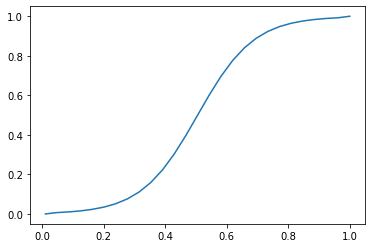

In [45]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = list(1 / (1 + np.exp(-threshold_list)))
threshold_list = [-0.0001] + threshold_list + [1.001] 
plt.plot(np.linspace(0.01, 1, threshold_number + 2), threshold_list)

In [47]:
val_loader = model_bce.val_dataloader()

  4%|▎         | 18/499 [00:00<00:02, 173.27it/s]

Loaded dataset from new_val/val_videoclips.pth


100%|██████████| 499/499 [00:02<00:00, 169.65it/s]

Good clips: 887
Only ones: 564
Without labels: 146


In [50]:
custom_model.model.to(device)
_, _, delay_list_custom, fp_delay_list_custom = metrics.get_pareto_metrics_for_threshold(custom_model.model, val_loader, 16, 16, threshold_list, device='cuda:0')
print("CUSTOM")





TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)






TP: 10 TN: 0 FP: 877 FN: 0 DELAY: 0.012401352874859075 FP_DELAY 0.7034949267192785




TP: 27 TN: 1 FP: 859 FN: 0 DELAY: 0.02818489289740699 FP_DELAY 1.8726042841037205




TP: 42 TN: 1 FP: 844 FN: 0 DELAY: 0.05749718151071026 FP_DELAY 2.6956031567080045




TP: 56 TN: 1 FP: 830 FN: 0 DELAY: 0.08568207440811725 FP_DELAY 3.37880496054115




TP: 66 TN: 1 FP: 820 FN: 0 DELAY: 0.11837655016910936 FP_DELAY 3.9808342728297634




TP: 84 TN: 1 FP: 802 FN: 0 DELAY: 0.1657271702367531 FP_DELAY 4.497181510710259




TP: 89 TN: 1 FP: 797 FN: 0 DELAY: 0.21307779030439683 FP_DELAY 4.98196166854566




TP: 104 TN: 2 FP: 781 FN: 0 DELAY: 0.26719278466741825 FP_DELAY 5.412626832018038




TP: 111 TN: 3 FP: 771 FN: 2 DELAY: 0.32130777903043967 FP_DELAY 5.826381059751973




TP: 120 TN: 6 FP: 759 FN: 2 DELAY: 0.3697857948139797 FP_DELAY 6.157835400225479




TP: 123 TN: 10 FP: 750 FN: 4 DELAY: 0.4295377677564825 FP_DELAY 6.502818489289741




TP: 132 TN: 13 FP: 737 FN: 5 DELAY: 0.4813979706877114 F

In [51]:
model_bce.model.to(device)
_, _, delay_list_bce, fp_delay_list_nce = metrics.get_pareto_metrics_for_threshold(model_bce.model, val_loader, 16, 16, threshold_list, device='cuda:0')
print("BCE")





TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 53 TN: 126 FP: 648 FN: 60 DELAY: 0.7801578354002254 FP_DELAY 5.643742953776775




TP: 27 TN: 520 FP: 72 FN: 268 DELAY: 2.5434047350620066 FP_DELAY 15.162344983089064




TP: 0 TN: 577 FP: 2 FN: 308 DELAY: 2.7271702367531003 FP_DELAY 15.985343855693348




TP: 0 TN: 578 FP: 0 FN: 309 DELAY: 2.733934611048478 FP_DELAY 16.0




TP: 0 TN: 578 FP: 0 FN: 309 DELAY: 2.733934611048478 FP_DELAY 16.0




TP: 0 TN: 578 FP: 0 FN: 309 DELAY: 2.733934611048478 

In [52]:
model_combined_1.model.to(device)
_, _, delay_list_combined, fp_delay_list_combined = metrics.get_pareto_metrics_for_threshold(model_combined_2.model, val_loader, 16, 16, threshold_list, device='cuda:0')
print("COMB")





TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.007891770011273957




TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.12852311161217586




TP: 3 TN: 0 FP: 884 FN: 0 DELAY: 0.0 FP_DELAY 0.43404735062006766




TP: 9 TN: 0 FP: 878 FN: 0 DELAY: 0.009019165727170236 FP_DELAY 0.9875986471251409




TP: 21 TN: 0 FP: 866 FN: 0 DELAY: 0.02142051860202931 FP_DELAY 1.7023675310033821




TP: 38 TN: 0 FP: 849 FN: 0 DELAY: 0.048478015783540024 FP_DELAY 2.5343855693348365




TP: 49 TN: 7 FP: 831 FN: 0 DELAY: 0.09131905298759865 FP_DELAY 3.43630214205186




TP: 65 TN:

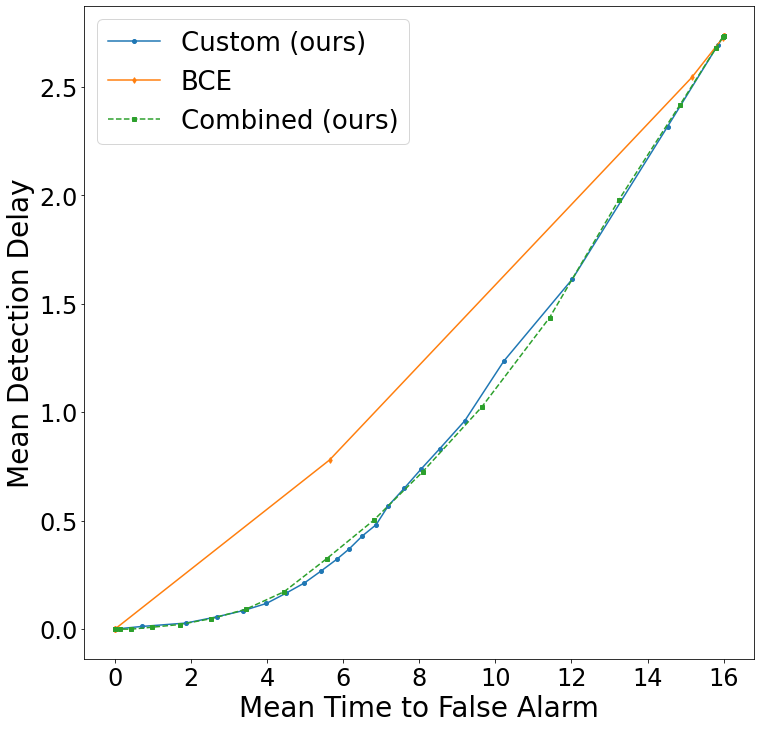

In [59]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_custom, delay_list_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_nce, delay_list_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_combined, delay_list_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('oops_curve.pdf', bbox_inches='tight')

In [56]:
batch, labels, _ = next(iter(val_loader))

In [64]:
custom_model.model.to('cuda:1')
metrics.save_metrics_to_file_new_version('Custom', custom_model.model, val_loader, batch_size=16,
                                         seq_len=16, fp_delay=fp_delay_list_custom, threshold_list=threshold_list, 
                                         x_coord_arr=[2, 4, 6, 8], path_to_save = "")

1.8726042841037205 0.010117362974975634 2.6956031567080045 0.015267153880374444 2
TP: 31 TN: 1 FP: 855 FN: 0 DELAY: 0.03156708004509583 FP_DELAY 2.0428410372040586
3.9808342728297634 0.03444519566621118 4.497181510710259 0.05133579311531625 4


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TP: 67 TN: 1 FP: 819 FN: 0 DELAY: 0.12175873731679819 FP_DELAY 4.0045095828635855
5.826381059751973 0.15886910488091516 6.157835400225479 0.22270013882530884 6
TP: 118 TN: 6 FP: 761 FN: 2 DELAY: 0.3528748590755355 FP_DELAY 6.020293122886133
7.611048478015784 0.6026853379784918 8.03945885005637 0.6970592839654074 8
TP: 153 TN: 30 FP: 689 FN: 15 DELAY: 0.7305524239007892 FP_DELAY 7.996617812852311


In [65]:
metrics.area_under_graph(delay_list_custom, fp_delay_list_custom)

15.02119745439894

In [66]:
model_bce.model.to('cuda:1')
metrics.save_metrics_to_file_new_version('BCE', model_bce.model, val_loader, batch_size=16,
                                         seq_len=16, fp_delay=fp_delay_list_custom, threshold_list=threshold_list, 
                                         x_coord_arr=[2, 4, 6, 8], path_to_save = "")

1.8726042841037205 0.010117362974975634 2.6956031567080045 0.015267153880374444 2
TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0
3.9808342728297634 0.03444519566621118 4.497181510710259 0.05133579311531625 4


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TP: 0 TN: 0 FP: 887 FN: 0 DELAY: 0.0 FP_DELAY 0.0
5.826381059751973 0.15886910488091516 6.157835400225479 0.22270013882530884 6
TP: 5 TN: 10 FP: 871 FN: 1 DELAY: 0.02705749718151071 FP_DELAY 0.5073280721533259
7.611048478015784 0.6026853379784918 8.03945885005637 0.6970592839654074 8
TP: 0 TN: 578 FP: 0 FN: 309 DELAY: 2.733934611048478 FP_DELAY 16.0


In [67]:
metrics.area_under_graph(delay_list_bce, fp_delay_list_nce)

20.228197857312626

In [68]:
model_combined_1.model.to('cuda:1')
metrics.save_metrics_to_file_new_version('Combined', model_combined_1.model, val_loader, batch_size=16,
                                         seq_len=16, fp_delay=fp_delay_list_custom, threshold_list=threshold_list, 
                                         x_coord_arr=[2, 4, 6, 8], path_to_save = "")

1.8726042841037205 0.010117362974975634 2.6956031567080045 0.015267153880374444 2
TP: 14 TN: 0 FP: 873 FN: 0 DELAY: 0.0011273957158962795 FP_DELAY 0.770011273957159
3.9808342728297634 0.03444519566621118 4.497181510710259 0.05133579311531625 4


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TP: 27 TN: 0 FP: 860 FN: 0 DELAY: 0.011273957158962795 FP_DELAY 1.6234498308906427
5.826381059751973 0.15886910488091516 6.157835400225479 0.22270013882530884 6
TP: 45 TN: 0 FP: 841 FN: 1 DELAY: 0.036076662908680945 FP_DELAY 2.5366403607666292
7.611048478015784 0.6026853379784918 8.03945885005637 0.6970592839654074 8
TP: 68 TN: 13 FP: 801 FN: 5 DELAY: 0.1657271702367531 FP_DELAY 3.986471251409245


In [69]:
metrics.area_under_graph(delay_list_combined, fp_delay_list_combined)

14.965453010985437

In [74]:
model = Combine()
model_pl = CPD_model(model)

In [75]:
val_loader = model_pl.val_dataloader()

  3%|▎         | 16/499 [00:00<00:03, 159.12it/s]

Loaded dataset from new_val/val_videoclips.pth


100%|██████████| 499/499 [00:03<00:00, 160.40it/s]

Good clips: 887
Only ones: 564
Without labels: 146


In [108]:
batch, labels, _ = next(iter(val_loader))

In [109]:
labels[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

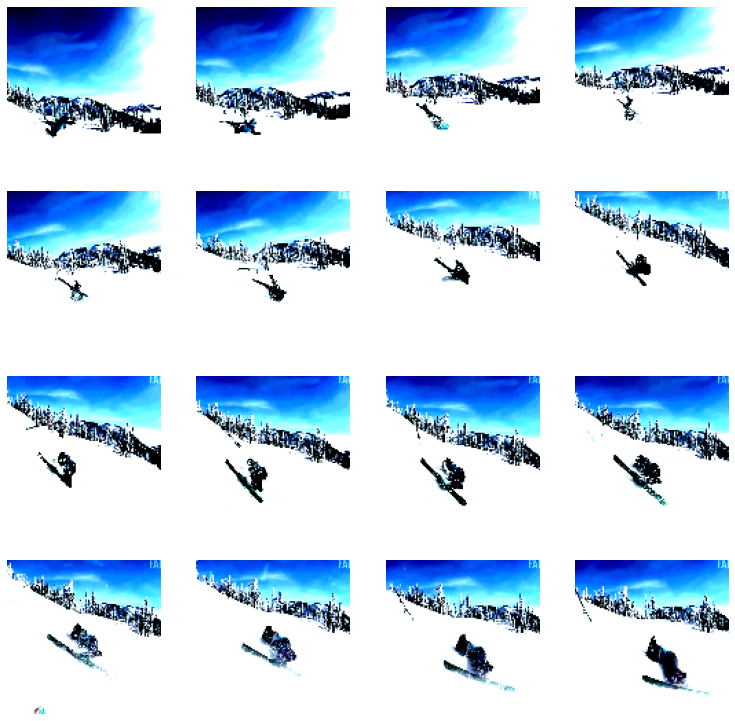

In [99]:
IM_SIZE = 224
i = 0
fig, axs = plt.subplots(4, 4, figsize=(13, 13))
# for ind in range(seq_len):
imgs = batch[7].transpose(0, 1)
for index in range(16):
    first_index = int(index / 4)
    second_index = index % 4
    axs[first_index, second_index].set_axis_off()
    axs[first_index, second_index].imshow(imgs[index].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
#plt.savefig('oops_normal.pdf', bbox_inches='tight')